In [2]:
import os
import sys
from pathlib import Path

import cv2 as cv
import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
from joblib import Parallel, delayed
from skimage import exposure, io
from skimage.util import img_as_ubyte
from tqdm.notebook import tqdm, trange

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"
match_info_dir = data_dir / "match"

In [4]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils
import transform 

In [5]:
experiment = "Lung"
cores = ['B5', 'C6', 'D4', 'E4', 'E6', 'F4']
datasets = [f'{core}_{i}' for core in cores for i in range(1,5)] + ['F7_3', 'F7_4']


In [14]:
from skimage.measure import regionprops_table

# Read mask image
def get_masks(mask_folder, dataset):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name and dataset in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks

In [20]:
masks = get_masks(data_dir / "masks", f"{experiment}")
dfs = []
for i, dataset in enumerate(datasets):
    try:
        mask = masks["_".join([experiment, dataset])]
        props = regionprops_table(mask, properties=['axis_major_length', 'axis_minor_length'])

        df = pd.DataFrame(props)
        df['Dataset'] = dataset
        dfs.append(df)
    except:
        continue

In [29]:
df = pd.concat(dfs)
df.columns = ['Major', 'Minor', 'Dataset']
df_melt = df.melt(value_vars=['Major', 'Minor'], var_name='Axis', value_name='Diameter')

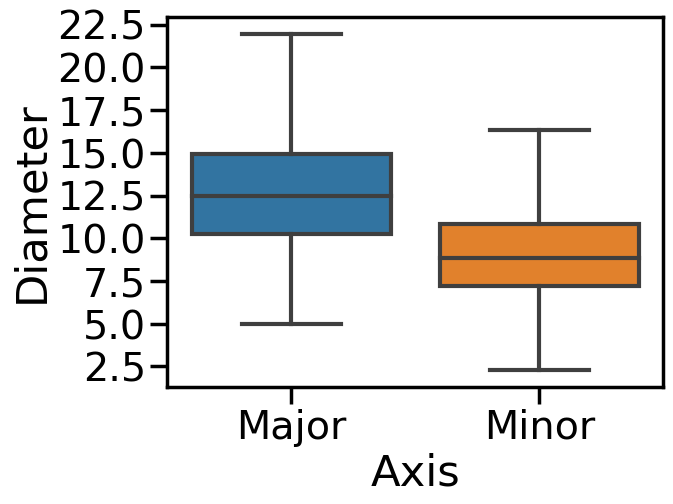

In [35]:
import seaborn as sns

with sns.plotting_context('poster', font_scale=1.3):
    sns.boxplot(data=df_melt, x='Axis', y='Diameter', showfliers=False)